# Image Captioning EDA
Ananya Chattoraj

cananya53@gmail.com

### Introduction to the Dataset
The dataset is the Flickr 8k images + captions dataset from Kaggle found [here](https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions).

### EDA Process
Since this dataset contains both visual and natural language data, I will first split up their EDA. 

Beginning with natural language data, the captions, I will observe the frequency of words to gauge the types of content available within the images (assuming the captions are in fact, reflective of the images).

THEN MORE STUFF

Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from PIL import Image
import os
import random
import glob
from sklearn.model_selection import train_test_split

Load in the captions as a data frame

In [2]:
caption = pd.read_csv('flickr8k/captions.txt')
caption.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
caption.shape

(40455, 2)

In [4]:
caption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [5]:
caption.isna().sum()

image      0
caption    0
dtype: int64

Thankfully, this is already a relatively clean caption set in the sense of missing values. The text will still need to be cleaned in the sense of preprocessing.

## IMAGES

In [6]:
#getting image files
imagefolder = 'flickr8k/images/'

In [7]:
#list of all image paths
imagefiles = glob.glob(imagefolder + '/*.jpg')
imagefiles

['flickr8k/images\\1000268201_693b08cb0e.jpg',
 'flickr8k/images\\1001773457_577c3a7d70.jpg',
 'flickr8k/images\\1002674143_1b742ab4b8.jpg',
 'flickr8k/images\\1003163366_44323f5815.jpg',
 'flickr8k/images\\1007129816_e794419615.jpg',
 'flickr8k/images\\1007320043_627395c3d8.jpg',
 'flickr8k/images\\1009434119_febe49276a.jpg',
 'flickr8k/images\\1012212859_01547e3f17.jpg',
 'flickr8k/images\\1015118661_980735411b.jpg',
 'flickr8k/images\\1015584366_dfcec3c85a.jpg',
 'flickr8k/images\\101654506_8eb26cfb60.jpg',
 'flickr8k/images\\101669240_b2d3e7f17b.jpg',
 'flickr8k/images\\1016887272_03199f49c4.jpg',
 'flickr8k/images\\1019077836_6fc9b15408.jpg',
 'flickr8k/images\\1019604187_d087bf9a5f.jpg',
 'flickr8k/images\\1020651753_06077ec457.jpg',
 'flickr8k/images\\1022454332_6af2c1449a.jpg',
 'flickr8k/images\\1022454428_b6b660a67b.jpg',
 'flickr8k/images\\1022975728_75515238d8.jpg',
 'flickr8k/images\\102351840_323e3de834.jpg',
 'flickr8k/images\\1024138940_f1fefbdce1.jpg',
 'flickr8k/image

In [8]:
#I'll want to see some of the images, so define function to display them
def display_image(ipath):
    images = Image.open(ipath)
    plt.imshow(images)
    plt.show()

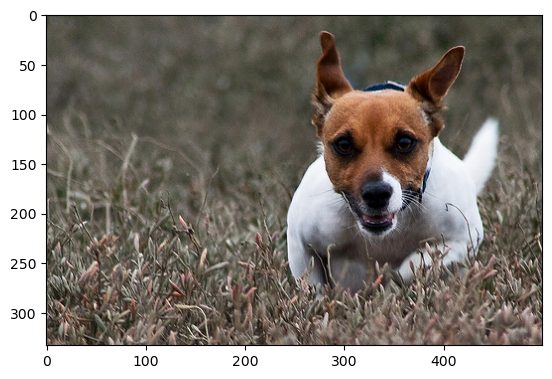

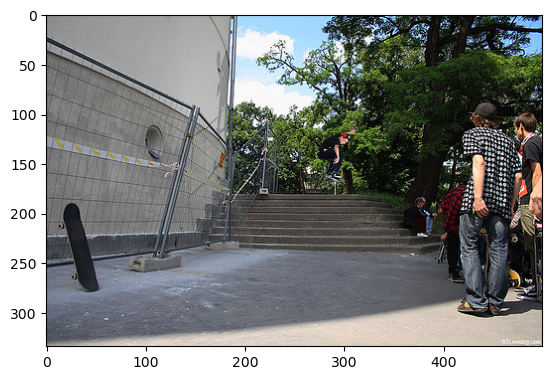

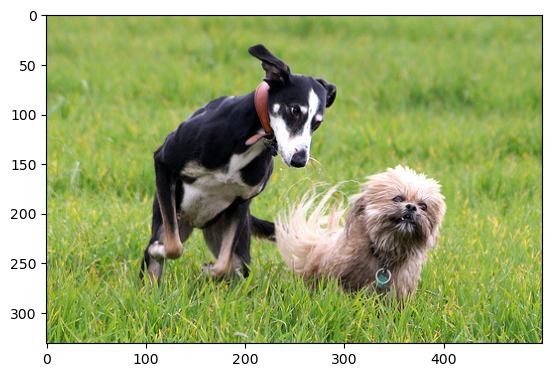

In [9]:
#display 3 random images for sanity check 
randomimages = random.sample(imagefiles,3)
for r in randomimages:
    display_image(r)


In [10]:
ipathsdf = pd.DataFrame({'paths':imagefiles})
ipathsdf.head()

,paths
0,flickr8k/images\1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg


In [11]:
ipathsdf['image'] = ipathsdf['paths'].apply(lambda path: path.split('\\')[-1])
ipathsdf.head()

,paths,image
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg
1,flickr8k/images\1001773457_577c3a7d70.jpg,1001773457_577c3a7d70.jpg
2,flickr8k/images\1002674143_1b742ab4b8.jpg,1002674143_1b742ab4b8.jpg
3,flickr8k/images\1003163366_44323f5815.jpg,1003163366_44323f5815.jpg
4,flickr8k/images\1007129816_e794419615.jpg,1007129816_e794419615.jpg


In [12]:
mergeddf = ipathsdf.merge(caption, on='image', how='left')

In [13]:
mergeddf.head()

,paths,image,caption
0,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,flickr8k/images\1000268201_693b08cb0e.jpg,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [14]:
mergeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   paths    40455 non-null  object
 1   image    40455 non-null  object
 2   caption  40455 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [15]:
#checkpoint
mergeddf.to_pickle('image_captions')

I should look at some pictures and one of their captions together to make sure it makes sense.

In [16]:
from textwrap import wrap

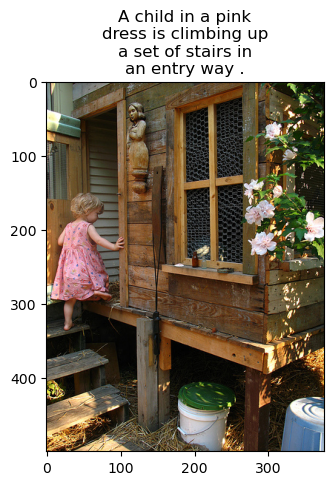

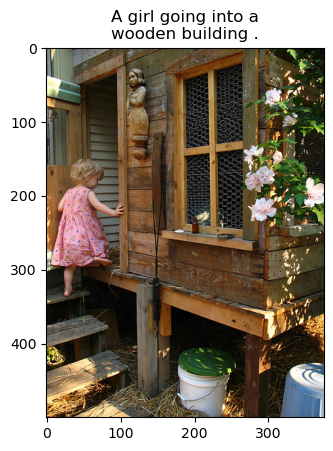

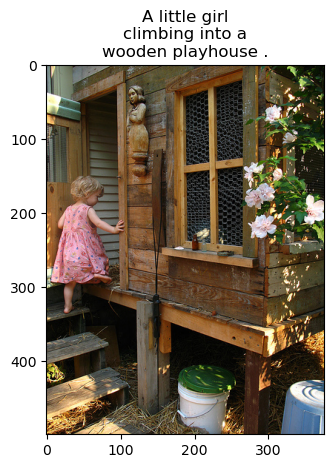

In [17]:
imagelist = mergeddf['paths'].tolist()
captionlist = mergeddf['caption'].tolist()
pairs = list(zip(imagelist,captionlist))
samples = pairs[:3]
#samples = random.sample(pairs,3)
for p, c in samples:
    plt.title("\n".join(wrap(c, 20)))
    display_image(p)
    plt.show

I should find out approximately how many captions are associated with each image.

In [18]:
mergeddf.groupby(['image'])['caption'].count().describe()

count    8091.0
mean        5.0
std         0.0
min         5.0
25%         5.0
50%         5.0
75%         5.0
max         5.0
Name: caption, dtype: float64

Should group all the captions for a single image together.

In [19]:
groupeddf= mergeddf[['paths', 'caption']]
groupeddf.head()

,paths,caption
0,flickr8k/images\1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,flickr8k/images\1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [20]:
groupeddf['caption_order'] = groupeddf.groupby(['paths']).cumcount()+1
groupeddf

,paths,caption,caption_order
0,flickr8k/images\1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,1
1,flickr8k/images\1000268201_693b08cb0e.jpg,A girl going into a wooden building .,2
2,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,3
3,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,4
4,flickr8k/images\1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,5
...,...,...,...
40450,flickr8k/images\997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,1
40451,flickr8k/images\997722733_0cb5439472.jpg,A man is rock climbing high in the air .,2
40452,flickr8k/images\997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,3
40453,flickr8k/images\997722733_0cb5439472.jpg,A rock climber in a red shirt .,4


In [21]:
groupeddf = groupeddf.pivot(index='paths', columns='caption_order', values='caption').reset_index()

In [22]:
groupeddf

caption_order,paths,1,2,3,4,5
0,flickr8k/images\1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,flickr8k/images\1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,flickr8k/images\1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,flickr8k/images\1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,flickr8k/images\1007129816_e794419615.jpg,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...
...,...,...,...,...,...,...
8086,flickr8k/images\990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...,A man is doing a wheelie on a mountain bike .,A man on a bicycle is on only the back wheel .,Asian man in orange hat is popping a wheelie o...,Man on a bicycle riding on only one wheel .
8087,flickr8k/images\99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .,A group of people sit atop a snowy mountain .,A group of people sit in the snow overlooking ...,Five children getting ready to sled .,Five people are sitting together in the snow .
8088,flickr8k/images\99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...,A large bird stands in the water on the beach .,A tall bird is standing on the sand beside the...,A water bird standing at the ocean 's edge .,A white crane stands tall as it looks out upon...
8089,flickr8k/images\997338199_7343367d7f.jpg,A person stands near golden walls .,a woman behind a scrolled wall is writing,A woman standing near a decorated wall writes .,The walls are covered in gold and patterns .,"Woman writing on a pad in room with gold , dec..."


In [23]:
#pickle time
groupeddf.to_pickle('captions_by_path')

For simplicity of modeling, I want to separate out just a single caption per image. I'll do this for each of the captions, and just pickle them all for modeling.

In [24]:
groupeddf[['paths', 1]].to_pickle('caption1')
groupeddf[['paths', 2]].to_pickle('caption2')
groupeddf[['paths', 3]].to_pickle('caption3')
groupeddf[['paths', 4]].to_pickle('caption4')
groupeddf[['paths', 5]].to_pickle('caption5')